In [534]:
#data stuff
import time
import pandas as pd
import numpy as np
import datetime as dt

#regression stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#graph stuff
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

__Define functions for easier plotting__

In [457]:
def plot_variables_func(df,plot_list, one_plot=False, title=None, monthly=False):
    if monthly == False:
        x = pd.date_range(df.index.min(), df.index.max())
        y_df = df.copy()
        y_df = y_df.reindex(x)
        plot_me = plot_list
        data = []
        palette =[
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        ]

        for i in range(len(plot_me)):
            # Create a trace
            trace = go.Scatter(
                x = df.index,
                y = df.loc[:,plot_me[i]],
                name = plot_me[i],
                line = dict(color = palette[i])
            )

            if one_plot == False:
                data = [trace]
                layout=go.Layout(title=plot_me[i])

                plotly.offline.iplot(go.Figure(data=data, layout=layout), filename='basic-line')
            else:
                data.append(trace)

        if one_plot == True:
            layout=go.Layout(title=title,
                            legend=dict(orientation='h',xanchor = "center",x = 0.5))
            plotly.offline.iplot(go.Figure(data=data, layout = layout), filename='scatter-mode')
    else:
        aggre = {plot_list[i]:'sum' for i in range(len(plot_list))}
        if isinstance(df.index, pd.DatetimeIndex) == False:
            df_m = df.set_index('dte').groupby(pd.Grouper(freq='M')).agg(aggre)
        else:
            df_m = df.groupby(pd.Grouper(freq='M')).agg(aggre)

        plot_me = plot_list
        data = []
        for i in range(len(plot_me)):
            # Create a trace
            trace = go.Scatter(
                x = df_m.index,
                y = df_m.loc[:,plot_me[i]],
                name = plot_me[i]
            )

            if one_plot == False:
                data = [trace]
                layout=go.Layout(title=plot_me[i])
                plotly.offline.iplot(go.Figure(data=data, layout=layout), filename='basic-line')
            else:
                data.append(trace)

        if one_plot == True:
            plotly.offline.iplot(go.Figure(data=data), filename='scatter-mode')

In [458]:
def plot_variables(df, plot_list, one_plot=False, title=None, monthly=False, scaled=False):
    if scaled == True:
        df_scale = df[plot_list]
        for col in df_scale.columns:
            x = df_scale[[col]].values.astype(float)
            min_max_scaler = MinMaxScaler(feature_range=(0,1))
            x_scaled = min_max_scaler.fit_transform(x)
            df_scale[col] = x_scaled
        plot_variables_func(df_scale, plot_list, one_plot=one_plot, title=title, monthly=monthly)
    else:
        plot_variables_func(df, plot_list, one_plot=one_plot, title=title, monthly=monthly)

__function for corr matrix__

In [860]:
def get_corr_matrix(df, var_list, start, end, fontsize=12):

#     label_list = [x.partition('_adstock')[0] for x in var_list]
#     label_list = [x.partition('_impressions')[0] for x in label_list]
#     label_list = [x.replace("fixed"," ") for x in label_list]
#     label_list = [x.replace("_"," ").title() for x in label_list]
    label_list = var_list


    corr = df.loc[start:end][var_list].corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(15, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, 
#                 xticklabels=label_list, 
#                 yticklabels=label_list, 
                mask=mask, 
                cmap=cmap, 
                vmin=-1,
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                annot=True, 
                annot_kws={"size":fontsize}, 
                fmt='.1g'
               )
    plt.tight_layout()

# 0.1 Read in PMD Data

Note: the cell below takes forever to run. The table it's querying is quite large so that's probably why. As a workaround, I am querying the table in chunks in the cell below. However, it still takes forever...

In [ ]:
q = '''
-- with base as (
-- SELECT account
--     , attr_window
--     , campaign
--     , _match
--     , campaign_objective
--     , date
--     , marketing_initiative
--     , marketing_segment
--     , marketing_subinitiative
--     , channel
--     , platform
--     , sum(spend) spend
--     , sum(clicks) clicks
--     , sum(impressions) impressions
--     , sum(case
--             when sor_prod = 'Core' then conversions else null end) digi_conversions
--     , sum(case
--             when sor_prod = 'Crosswords' then conversions else null end) games_conversions
--     , sum(case
--             when sor_prod = 'EDU' then conversions else null end) edu_conversions
--     , sum(case
--             when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
--     , sum(case
--             when sor_prod = 'CK' then conversions else null end) ck_conversions     
--     , sum(case
--             when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
--     , sum(case
--             when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
-- FROM `nyt-mkt-prd.paid_media_data.placement_daily`
-- WHERE _PARTITIONTIME >= '2020-01-01' and attr_window in('Media Reported','Media Reported - Click Thru','Media Reported - View Thru')
-- group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)

-- select *
-- from base

select * 
from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21` 
'''

df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

Notes on use of attribution window:
* Use the same attr_window for each channel
* Media team right now uses _combined_ attr_window, which is mostly Media Reported but some quirks
* For this analysis, we should use:
    * __Combined__ and __Media Reported - Click Thru__
* Do one version that looks only at Media Reported click thru and one version that looks at combined


In [22]:
increment=200000
chunks=list(range(0, 1838251, increment))

chunks[-1]+=increment 
intervals=[[chunks[i-1], chunks[i]+1] for i, e in enumerate(chunks) if i > 0]

query_str='''
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit {end} offset {start}
'''

df = pd.DataFrame() 

for start, end in intervals:  
    q = query_str.format(start=start, end=end)
    print(f"running query: {q}")
    start_time = time.time()  
    temp_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)
    print(f'time took: {str(round(time.time() - start_time, 2))}')
    df = pd.concat([df, temp_df])

running query: 
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit 200001 offset 0

time took: 43.2
running query: 
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit 400001 offset 200000

time took: 71.5
running query: 
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit 600001 offset 400000

time took: 115.98
running query: 
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit 800001 offset 600000

time took: 144.29
running query: 
select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
order by

In [27]:
#keep a copy of the original just to be safe
df_safe = df.copy()

In [798]:
df = df_safe.copy()

In [799]:
#idk why there's duplicates but there are... so drop them
df.drop_duplicates(inplace=True)

In [29]:
df.to_csv('all_pmd_data_jan_20_to_apr_21.csv')

In [31]:
pd.set_option('display.max_columns', 500)

__Critical open question:__
* Which attr_window should we be looking at for this analysis? What difference does it make if we choose e.g. Media Reported versus 7 Day All?

## Checkpoint: read in data from CSV here if needed. Begin to limit data to just Core media activity

#### Clean the Data

In [800]:
#limit to Core campaigns 
df_core = df[df['marketing_subinitiative'].isin(['Core','CORE Business'])]

#remove mobile partners - conversion data is unreliable in PMD
df_core = df_core[~(df_core['account'].str.contains('Twigeo')) & 
                 ~(df_core['account'] == 'The New York Times App')]

#remove app install and app-based campaigns so we focus only on web
df_core['campaign'] = df_core['campaign'].str.lower()
df_core = df_core[~df_core['campaign'].str.contains('app')]

#limit attribution window to media-reported. We may want to reexamine this analysis in the future using other windows
#such as 7d-all or 1d-all
df_core = df_core[df_core['attr_window'] == 'Media Reported']

In [801]:
#create date-based aggregation columns for easier grouping
df_core['year_month_cal'] = df_core['date'].dt.strftime('%Y-%m')
df_core['year_week_iso'] = df_core['date'].dt.strftime('%GW%V')
df_core['year_week_monday'] = df_core['date'].dt.to_period('W').apply(lambda r: r.start_time)

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [802]:
#create a composite channel-marketing-initiative column for a pd.melt
df_core['channel_mkt_init'] = df_core['channel'] + " - " + df_core['marketing_initiative']

# 1.1 Top level analysis on Core-to-SPG cross sell (Core campaigns driving CK or Games starts)

In [803]:
#understand overall impact 1 Jan 2020 - 7 Apr 2021
df_core[['core_conversions','games_conversions','ck_conversions']].sum()

core_conversions     845599.170385
games_conversions     13521.425198
ck_conversions        31270.514403
dtype: float64

__Since January 2020, web-based Core media (note: this analysis excludes app-based media) has generated 845k starts. It has also enerated 13.5k Games starts and 31.3k Cooking starts which have never been recognized!__

The most recent 5 year LTVs I found for Cooking and Games are as follows: 
* Cooking: $124

* Games: $97

In [804]:
games_val = 13521.425198 * 97
print(f'Games added value: {round(games_val, 2)}')
ck_val = 31270.514403 * 124
print(f'CK added value: {round(ck_val, 2)}')

print(f'Combined value: {round(games_val + ck_val, 2)}')

Games added value: 1311578.24
CK added value: 3877543.79
Combined value: 5189122.03


This means upon initial glance, web-based campaigns since Jan 2020 have generated nearly $5.2M in unrecognized value based on media reporting

In [805]:
df_core['spg_conversions'] = df_core['games_conversions'] + df_core['ck_conversions']

<ipython-input-863-bd3c2aecda41>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



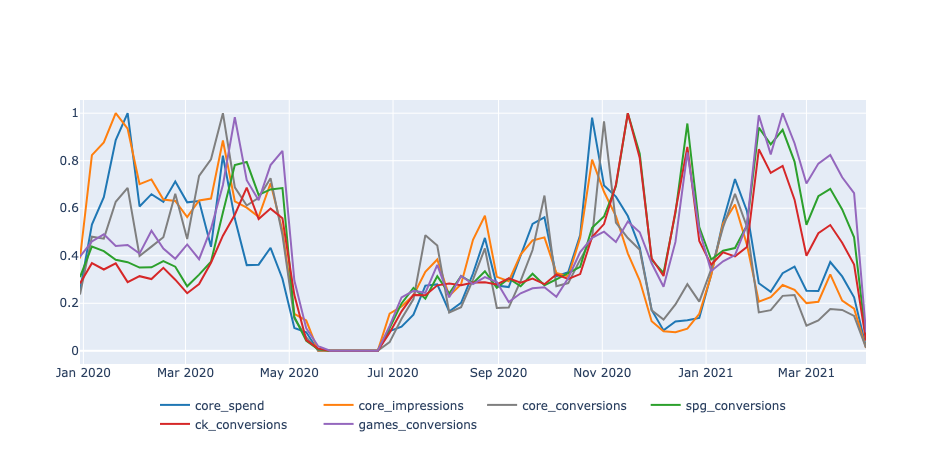

In [863]:
#create monthly view of impressions, core starts, spg starts
core_plt = df_core.groupby('year_week_monday')['spend','impressions','core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
core_plt.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions'},inplace=True)

plot_variables(core_plt, ['core_spend','core_impressions','core_conversions','spg_conversions',
                     'ck_conversions','games_conversions'], one_plot=True, scaled=True)

Looks like there's some relationship between Core impressions and SPG starts. Let's also layer in SPG impressions + spend to see whether that's having an effect as well. 

__add spg spend and impressions__

In [864]:
spg_df = df[(df['marketing_subinitiative'].isin(['Cooking','Games'])) & 
  ~(df['campaign'].str.contains('app'))]

spg_df['year_month_cal'] = spg_df['date'].dt.strftime('%Y-%m')
spg_df['year_week_iso'] = spg_df['date'].dt.strftime('%GW%V')

spg_df['year_week_monday'] = spg_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [865]:
#create summary to merge with plt
spg_df = spg_df.groupby('year_week_monday')['spend','impressions'].sum()
spg_df.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions'}, 
              inplace=True)

<ipython-input-865-52a922e74fad>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [866]:
core_plt.reset_index(inplace=True)
spg_df.reset_index(inplace=True)

In [867]:
#merge core and spg data
plt_merged = core_plt.merge(spg_df, how='left', on='year_week_monday').set_index('year_week_monday')

#get rid of nulls
plt_merged.fillna(0, inplace=True)

In [868]:
plt_merged.head()

,core_spend,core_impressions,core_conversions,spg_conversions,ck_conversions,games_conversions,spg_spend,spg_impressions
year_week_monday,,,,,,,,
2019-12-30,5.044026e+06,1.413683e+09,8565.609004,465.0000,353.0000,185.0,148661.450271,25007710.0
2020-01-06,1.058209e+07,2.994271e+09,17390.164743,658.0000,459.0000,215.0,241426.850964,32681586.0
2020-01-13,1.287259e+07,3.190278e+09,17082.499379,629.0000,426.0000,229.0,246642.970933,34403894.0
2020-01-20,1.766343e+07,3.636834e+09,22705.366117,573.8646,457.8646,206.0,219610.368966,34101025.0
2020-01-27,1.991867e+07,3.399427e+09,24820.531121,559.0000,360.0000,208.0,51574.950200,11065481.0


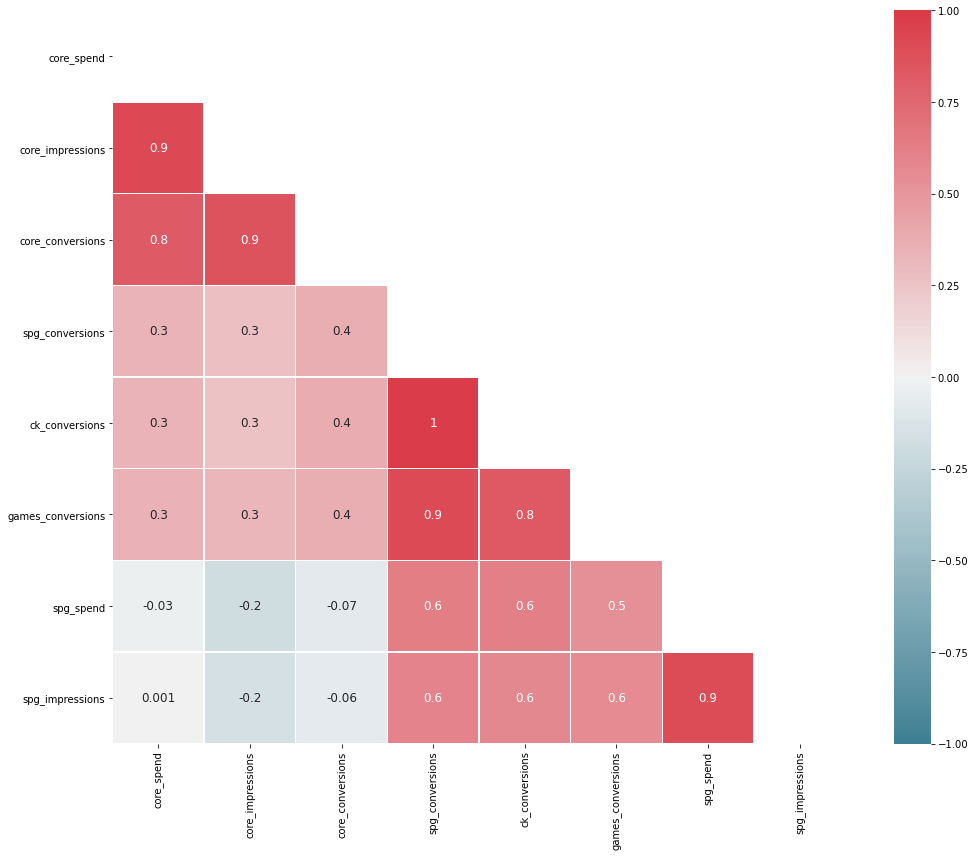

In [869]:
get_corr_matrix(plt_merged, plt_merged.columns.values, start=plt_merged.index.values.min(), end=plt_merged.index.values.max())

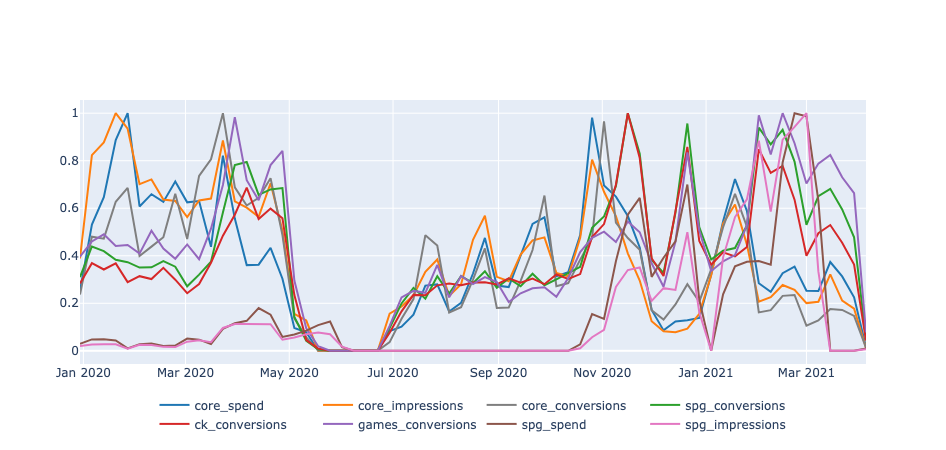

In [872]:
plot_variables(plt_merged, plt_merged.columns, one_plot=True, scaled=True)

# 2. Capture basic info on cross-sell (Cooking Only)

# 2.2 Identify cross-sell patterns (CK)

__Look at volumes__

In [203]:
mkt_init_vol = df_core.groupby(['marketing_initiative'])['impressions', 'ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
mkt_init_vol.reset_index(inplace=True)
mkt_init_vol['impression_weights'] = mkt_init_vol['impressions'] / mkt_init_vol['ck_conversions']
mkt_init_vol

<ipython-input-203-823081dc7d43>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mkt_init_vol = df_core.groupby(['marketing_initiative'])['impressions', 'ck_conversions'].sum().sort_values('ck_conversions', ascending=False)


,marketing_initiative,impressions,ck_conversions,impression_weights
0,Sale,4.488815e+10,13492.000000,3.327020e+06
1,Content/Audience Development,1.459660e+10,9068.000000,1.609682e+06
2,Business As Usual,2.239284e+10,7536.514403,2.971247e+06
3,One Day Sale,2.995480e+09,553.000000,5.416782e+06
4,Testing,2.890957e+07,175.000000,1.651976e+05
5,Branding,1.821180e+09,174.000000,1.046655e+07
6,Gifting,2.831936e+07,141.000000,2.008465e+05
7,Audience Content,4.378992e+07,76.000000,5.761832e+05
8,Brand,6.963704e+09,55.000000,1.266128e+08
9,Engagement,0.000000e+00,0.000000,NaN


In [209]:
mkt_init_vol.sort_values('impression_weights', ascending=True).head(5)

,marketing_initiative,impressions,ck_conversions,impression_weights
4,Testing,2.890957e+07,175.000000,1.651976e+05
6,Gifting,2.831936e+07,141.000000,2.008465e+05
7,Audience Content,4.378992e+07,76.000000,5.761832e+05
1,Content/Audience Development,1.459660e+10,9068.000000,1.609682e+06
2,Business As Usual,2.239284e+10,7536.514403,2.971247e+06


Sale, Content/Audience Dev, and BAU make up the vast majority of CK cross sells. However, this is mostly because of sheer impression volume. The most efficient tactics are those with the lowest impression weights - Testing, Gifting, Audience Content, Content/Audience Dev.

In [204]:
channel_vol = df_core.groupby(['channel'])['impressions','ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
channel_vol.reset_index(inplace=True)
channel_vol['impression_weights'] = channel_vol['impressions'] / channel_vol['ck_conversions']
channel_vol

<ipython-input-204-ee6c545260af>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  channel_vol = df_core.groupby(['channel'])['impressions','ck_conversions'].sum().sort_values('ck_conversions', ascending=False)


,channel,impressions,ck_conversions,impression_weights
0,Display,2.131944e+10,13255.000000,1.608408e+06
1,Native,1.829767e+10,8531.000000,2.144845e+06
2,Social,5.245194e+10,7529.000000,6.966654e+06
3,Paid Search,4.873372e+08,1916.514403,2.542831e+05
4,Video,2.664406e+08,33.000000,8.073958e+06
5,Connected Video,3.388028e+08,5.000000,6.776055e+07
6,Youtube,6.376860e+08,1.000000,6.376860e+08
7,Audio,5.324306e+07,0.000000,inf
8,Other,3.345927e+08,0.000000,inf
9,X-UNKNOWN-X,9.350242e+07,0.000000,inf


In [210]:
channel_vol.sort_values('impression_weights', ascending=True).head(5)

,channel,impressions,ck_conversions,impression_weights
3,Paid Search,4.873372e+08,1916.514403,2.542831e+05
0,Display,2.131944e+10,13255.000000,1.608408e+06
1,Native,1.829767e+10,8531.000000,2.144845e+06
2,Social,5.245194e+10,7529.000000,6.966654e+06
4,Video,2.664406e+08,33.000000,8.073958e+06


Display, Native and Social drove the most cross-sells. But Paid Search drove the most efficient cross-sells.

In [211]:
channel_mkt_vol = df_core.groupby('channel_mkt_init')['impressions','ck_conversions'].sum().sort_values('ck_conversions',ascending=False)
channel_mkt_vol.reset_index(inplace=True)
channel_mkt_vol['impression_weights'] = channel_mkt_vol['impressions'] / channel_mkt_vol['ck_conversions']
channel_mkt_vol.head(10)

<ipython-input-211-6ac1ec26bb9e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  channel_mkt_vol = df_core.groupby('channel_mkt_init')['impressions','ck_conversions'].sum().sort_values('ck_conversions',ascending=False)


,channel_mkt_init,impressions,ck_conversions,impression_weights
0,Display - Sale,1.330245e+10,8313.000000,1.600199e+06
1,Social - Content/Audience Development,4.347067e+09,4737.000000,9.176837e+05
2,Native - Content/Audience Development,1.024953e+10,4331.000000,2.366550e+06
3,Display - Business As Usual,5.924415e+09,4205.000000,1.408898e+06
4,Native - Sale,6.070621e+09,2989.000000,2.030987e+06
5,Social - Sale,2.531568e+10,1304.000000,1.941386e+07
6,Social - Business As Usual,1.429033e+10,1199.000000,1.191854e+07
7,Native - Business As Usual,1.896160e+09,1145.000000,1.656035e+06
8,Paid Search - Business As Usual,2.819391e+08,987.514403,2.855038e+05
9,Paid Search - Sale,1.994057e+08,879.000000,2.268552e+05


In [213]:
channel_mkt_vol.sort_values('impression_weights', ascending=True).head(10)

,channel_mkt_init,impressions,ck_conversions,impression_weights
24,Video - Branding,0.000000e+00,1.000000,0.000000
22,Video - Sale,0.000000e+00,7.000000,0.000000
17,Paid Search - Gifting,2.331609e+06,33.000000,70654.818182
13,Display - Gifting,1.460185e+07,108.000000,135202.277778
11,Display - Testing,2.890957e+07,175.000000,165197.560000
20,Paid Search - One Day Sale,3.660748e+06,17.000000,215338.117647
9,Paid Search - Sale,1.994057e+08,879.000000,226855.203641
8,Paid Search - Business As Usual,2.819391e+08,987.514403,285503.825611
14,Social - Audience Content,4.378992e+07,76.000000,576183.171053
1,Social - Content/Audience Development,4.347067e+09,4737.000000,917683.659278


Various Paid Search and Display tactics drove the most efficient cross-sell results. Meanwhile, Display Social and Native (Sale and Content/Audience Dev) drove the highest volume of cross-sells.

__Look at correlations__

In [103]:
#create monthly view
df_core_monthly = df_core.groupby(['year_month_cal','channel_mkt_init'])[['clicks','impressions','games_conversions','ck_conversions']].sum().reset_index()

#pivot to only have only one row per month
df_core_monthly = df_core_monthly.pivot(index='year_month_cal', columns='channel_mkt_init', values=['clicks','impressions','games_conversions','ck_conversions'])

In [104]:
#flatten index
df_core_monthly.columns = df_core_monthly.columns.to_flat_index()

In [155]:
#create one aggregate ck starts column for simpler correlations
df_core_monthly['ck_conversions_all'] = df_core_monthly[[col for col in df_core_monthly.columns if 'ck_conversions' in col]].sum(axis=1)

In [156]:
#start with just impressions and ck conversions
ck_imps_monthly = df_core_monthly[[col for col in df_core_monthly.columns if 'impressions' in col] + ['ck_conversions_all']]

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [158]:
#replace nans with 0 because it means there were no impressions in that period
ck_imps_monthly.fillna(0, inplace=True)

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [182]:
#get correlations between ck starts and impression volumes
ck_convs_imps_corr = ck_imps_monthly.corrwith(ck_imps_monthly['ck_conversions_all']).to_frame().rename(columns={0:'corr_with_ck_conv'}).reset_index()

#sort the frame
ck_convs_imps_corr.sort_values('corr_with_ck_conv', ascending=False, inplace=True)

In [185]:
ck_convs_imps_corr.head(20)

,index,corr_with_ck_conv
44,ck_conversions_all,1.000000
24,"(impressions, Paid Search - Sale)",0.661621
10,"(impressions, Display - Sale)",0.557228
15,"(impressions, Native - Sale)",0.532168
32,"(impressions, Social - Sale)",0.497982
25,"(impressions, Social - Audience Content)",0.459289
29,"(impressions, Social - Content/Audience Develo...",0.336473
30,"(impressions, Social - Gifting)",0.335716
13,"(impressions, Native - Content/Audience Develo...",0.301220
43,"(impressions, Youtube - X-UNKNOWN-X)",0.299430


Based on the above correlation chart, it seems that __sales__ have the strongest relationship with cross-sell starts. Major channels such as Paid Search, Display, Native, and Social show the highest correlation. That said, the highest correlation by far is Paid Search - Sale; other channels have modest relationships with CK conversions (~.50 or less)

This preliminary analysis would indicate that sale-based Core media does the best job attracting Cooking starts.

Social - Audience/Content also seems to do a fairly good job generating CK starts.

# 2.3 Try a Regression (CK)

cols to try: 
* campaign_objective
* marketing_initiative
* marketing_segment
* channel
* platform
* impressions
* core_conversions
* month dummy

In [414]:
#reduce number of cols 
df_reg = df_core[(df_core['channel'].isin(['Display','Native','Social','Paid Search'])) & 
                (df_core['marketing_initiative'].isin(['Sale','Content/Audience Development','Business As Usual','One Day Sale']))].groupby(['date','channel','marketing_initiative'])[['impressions','core_conversions','ck_conversions']].sum().reset_index()

In [415]:
df_reg.groupby(['date'])[['impressions','core_conversions','ck_conversions']].sum().corr()

,impressions,core_conversions,ck_conversions
impressions,1.000000,0.822089,0.203670
core_conversions,0.822089,1.000000,0.260833
ck_conversions,0.203670,0.260833,1.000000


In [416]:
#create month and weekday cols for dummies
df_reg['weekday'] = df_reg['date'].apply(lambda x: x.strftime('%A'))
df_reg['month'] = df_reg['date'].dt.month_name()

#create a merge dummies 
df_reg = pd.concat([df_reg, 
                  pd.get_dummies(df_reg['channel'], prefix='channel'),
                 pd.get_dummies(df_reg['marketing_initiative'], prefix='mkt_init'), 
               pd.get_dummies(df_reg['weekday'], prefix='weekday'), 
               pd.get_dummies(df_reg['month'], prefix='month')], axis=1)

#drop old cols and set index to date
df_reg.drop(['channel','marketing_initiative','weekday','month'], axis=1, inplace=True)
df_reg.set_index('date', inplace=True)

# #add some holiday dummies for cooking 
# df_reg['xmas'] = 0
# df_reg.loc['2020-12-20':'2020-12-25', 'xmas'] = 1

# df_reg['thanksgiving'] = 0
# df_reg.loc['2020-11-22':'2020-11-25', 'thanksgiving'] = 1


In [418]:
df_reg = df_reg.groupby('date').agg({'impressions': 'sum',
                            'core_conversions':'sum',
                            'ck_conversions':'sum',
                            'channel_Display':'max',
                             'channel_Native':'max',
                             'channel_Paid Search':'max',
                             'channel_Social':'max',
                             'mkt_init_Business As Usual':'max',
                             'mkt_init_Content/Audience Development':'max',
                             'mkt_init_One Day Sale':'max',
                             'mkt_init_Sale':'max',
                             'month_April':'max',
                             'month_August':'max',
                             'month_December':'max',
                             'month_February':'max',
                             'month_January':'max',
                             'month_July':'max',
                             'month_June':'max',
                             'month_March':'max',
                             'month_May':'max',
                             'month_November':'max',
                             'month_October':'max',
                             'month_September':'max',
                             'weekday_Friday':'max',
                             'weekday_Monday':'max',
                             'weekday_Saturday':'max',
                             'weekday_Sunday':'max',
                             'weekday_Thursday':'max',
                             'weekday_Tuesday':'max',
                             'weekday_Wednesday':'max'})

In [419]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [420]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

<ipython-input-420-fc4db5e2a75b>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [421]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ck_conversions   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     23.95
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           1.39e-68
Time:                        11:00:12   Log-Likelihood:                -2113.6
No. Observations:                 450   AIC:                             4283.
Df Residuals:                     422   BIC:                             4398.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    12.8730     14.276      0.902      0.368     -15.188      40.934
impressions                             -39.6070     12.944     -3.060      0.002     -65.050     -14.164
core_conversions                         26.2904     15.798      1.664      0.097      -4.762      57.343
channel_Display                           0.3165     14.865      0.021      0.983     -28.901      29.534
channel_Native                           14.9341      9.309      1.604      0.109      -3.365      33.233
channel_Paid Search                      49.8547     15.039      3.315      0.001      20.294      79.415
channel_Social                            9.7824     12.611      0.776      0.438     -15.006      34.571
mkt_init_Business As Usual               -3.6459      5.745     -0.635      0.526     -14.938       7.647
mkt_init_Content/Audience Development   -12.9875      7.138     -1.819      0.070     -27.018       1.043
mkt_init_One Day Sale                    -5.4558      3.252     -1.678      0.094     -11.848       0.936
mkt_init_Sale                             0.4013      4.761      0.084      0.933      -8.957       9.760
month_April                              24.0380      6.341      3.791      0.000      11.573      36.503
month_August                            -13.8424      5.693     -2.432      0.015     -25.032      -2.653
month_December                           19.6425      5.581      3.520      0.000       8.673      30.612
month_February                           30.4206      4.795      6.344      0.000      20.995      39.846
month_January                             8.8974      5.328      1.670      0.096      -1.575      19.370
month_July                              -37.6183      6.017     -6.252      0.000     -49.445     -25.791
month_June                              -52.3341     11.865     -4.411      0.000     -75.655     -29.013
month_March                               5.7804      4.700      1.230      0.219      -3.458      15.018
month_May                               -14.7369     11.611     -1.269      0.205     -37.561       8.087
month_November                           62.3451      6.475      9.628      0.000      49.617      75.073
month_October                            -4.1815      5.737     -0.729      0.466     -15.458       7.095
month_September                         -15.5378      5.676     -2.737      0.006     -26.695      -4.380
weekday_Friday                           -1.6613      4.044     -0.411      0.681      -9.610       6.287
weekday_Monday                            5.7947      3.802      1.524      0.128      -1.678      13.267
weekday_Saturday                         13.0006      3.823      3.401      0.001       5.487      20.515
weekday_S

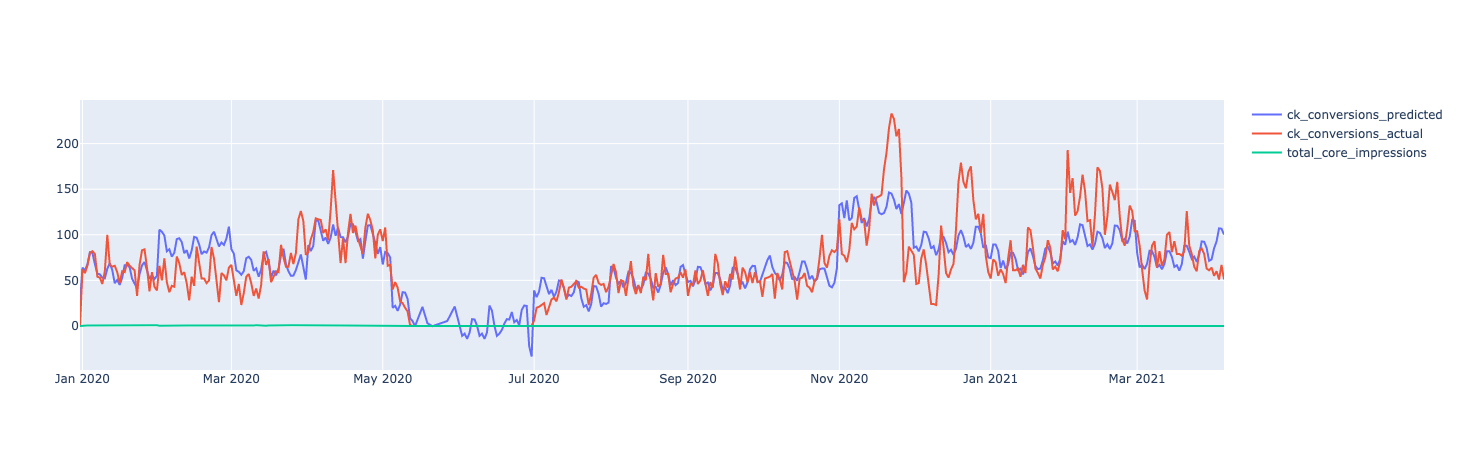

In [422]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

ols_daily = ols_vis.reset_index().groupby('date').sum()


fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

__Scaled version of residuals plot__

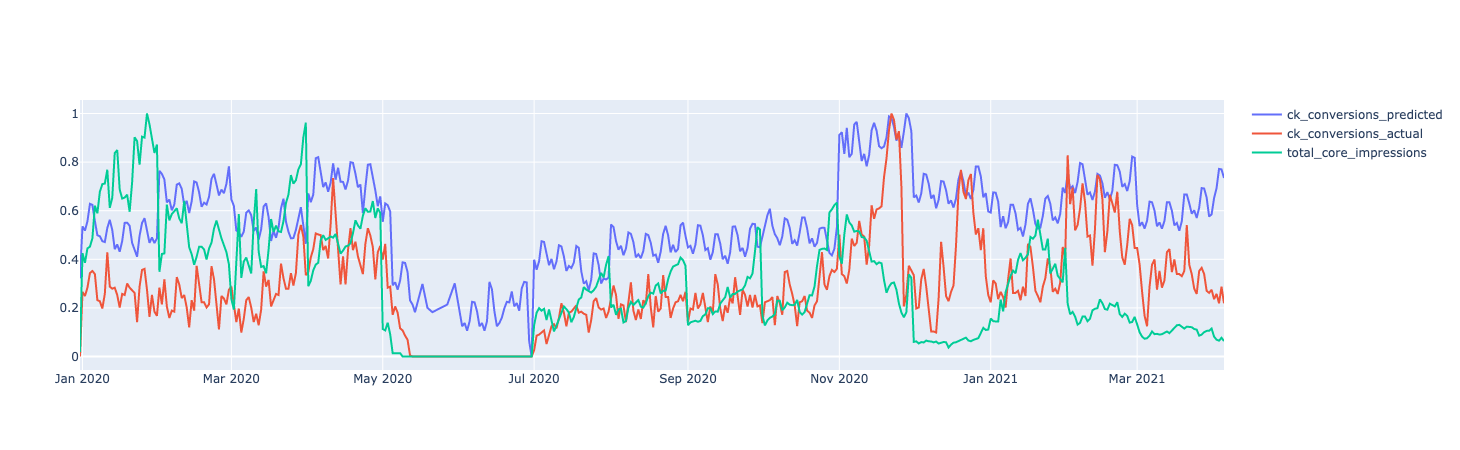

In [423]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

The initial pass was garbage. There are likely several reasons for this, but first and foremost is that we have too many independent variables, too few observations which include those independent variables, and independent variables that have little to no relationship with our dependent (in this case, Cooking starts). 

To refine the regression approach we need to do more EDA to understand which channels and tactics have the most explanatory power.

__NOTE: CK conversions drop to near zero in May through July, and also have major spikes around Thanksgiving and Xmas. Cooking media went dark in May through July, and also has the heaviest spend around the aforementioned holidays. The absence of Cooking starts during the dark period and the holiday spikes could indicate that these Cooking "cross sell" starts are really being driven by Cooking media, and the audiences also happened to be served Core ads which greedily picked up the credit. Need to explore this further - very important caveat to this analysis__

__Critical open question:__
* How do we remove the influence of Cooking/Games paid media that ran concurrently with Core paid media?

One possible solution could be to __only include click-through cross-sell conversions__ in this analysis. That way we can be a little more sure that it was, in fact, the Core ad that generated the CK or Games conversion. This would be a more conservative approach, but would mitigate the risk that we go on to calculate a blended CPO based on misattributed viewthrough conversions.

### Try two model improvements, separately: 

#### A) just look at click-thru conversions
#### B) add in CK spend/impressions to regression and see how it correlates / comes into the model 

In [424]:
ck_daily = df[(df['marketing_subinitiative'] == 'Cooking') & 
  (df['attr_window'] == 'Media Reported') & 
  (df['marketing_initiative'] != 'App Download') & 
  ~(df['campaign'].str.contains('app'))]

ck_daily['date'] = ck_daily['date'].astype('datetime64[ns]')

ck_daily = ck_daily.groupby('date').sum().reset_index()

<ipython-input-424-63d15dd1c72d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [425]:
ck_daily.rename(columns = {'impressions':'ck_impressions',
                          'spend':'ck_spend'}, inplace=True)

In [426]:
df_reg.reset_index(inplace=True)
df_reg['date'] = df_reg['date'].astype('datetime64[ns]')

In [427]:
df_reg = df_reg.merge(ck_daily[['date','ck_impressions']], how='left', on='date').fillna(0)
df_reg.set_index('date', inplace=True)

In [428]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [429]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

<ipython-input-429-fc4db5e2a75b>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [430]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ck_conversions   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     33.66
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           1.25e-89
Time:                        11:00:29   Log-Likelihood:                -2058.2
No. Observations:                 450   AIC:                             4174.
Df Residuals:                     421   BIC:                             4294.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2207     12.693      0.017      0.986     -24.728      25.169
impressions                               4.5975     12.164      0.378      0.706     -19.313      28.508
core_conversions                          7.1950     14.097      0.510      0.610     -20.514      34.904
channel_Display                           3.0719     13.162      0.233      0.816     -22.800      28.944
channel_Native                           14.5908      8.242      1.770      0.077      -1.610      30.791
channel_Paid Search                      42.3038     13.333      3.173      0.002      16.097      68.510
channel_Social                            9.3411     11.165      0.837      0.403     -12.605      31.287
mkt_init_Business As Usual               -0.5198      5.094     -0.102      0.919     -10.533       9.494
mkt_init_Content/Audience Development    -7.7463      6.338     -1.222      0.222     -20.204       4.712
mkt_init_One Day Sale                    -3.7893      2.883     -1.314      0.189      -9.456       1.878
mkt_init_Sale                            -2.6710      4.225     -0.632      0.528     -10.975       5.633
month_April                              24.0771      5.614      4.289      0.000      13.042      35.112
month_August                             -8.1820      5.067     -1.615      0.107     -18.142       1.778
month_December                           13.8134      4.970      2.779      0.006       4.045      23.582
month_February                            6.6149      4.780      1.384      0.167      -2.781      16.011
month_January                            -8.9614      4.997     -1.793      0.074     -18.783       0.860
month_July                              -28.4550      5.394     -5.276      0.000     -39.057     -17.853
month_June                              -38.5724     10.581     -3.646      0.000     -59.370     -17.775
month_March                              -1.1946      4.210     -0.284      0.777      -9.470       7.081
month_May                                -1.4450     10.353     -0.140      0.889     -21.795      18.905
month_November                           52.3954      5.806      9.025      0.000      40.984      63.807
month_October                            -1.3667      5.086     -0.269      0.788     -11.363       8.630
month_September                          -8.5032      5.067     -1.678      0.094     -18.463       1.457
weekday_Friday                           -4.3842      3.589     -1.222      0.223     -11.439       2.670
weekday_Monday                            5.0620      3.366      1.504      0.133      -1.555      11.679
weekday_Saturday                         10.6949      3.391      3.154      0.002       4.029      17.360
weekday_S

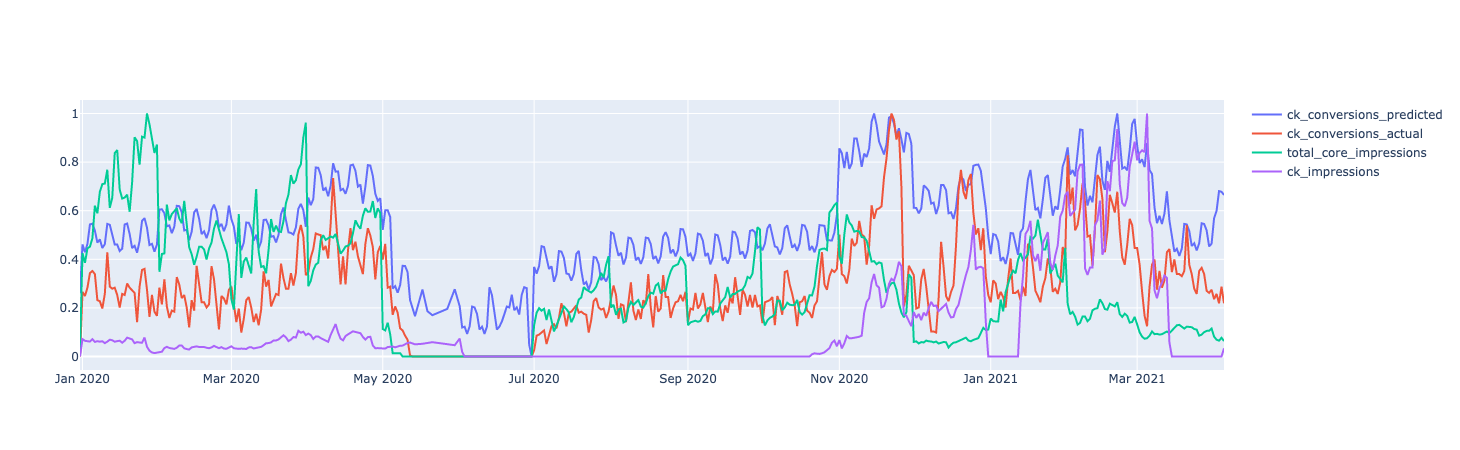

In [433]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['ck_impressions'],
                    mode='lines',
                    name='ck_impressions'))

fig.show()

# 3 Try regression again - with all data and impression volumes across channel_mkt_init

__construct impressions, clicks, and starts columns__

In [883]:
reg_df = df_core.groupby(['date','channel_mkt_init'])['clicks','impressions','spend','core_conversions','spg_conversions'].sum().reset_index()

<ipython-input-883-faa08e6d002f>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [884]:
reg_df = reg_df.pivot(index='date', columns='channel_mkt_init', values=['clicks','impressions','spend','core_conversions','spg_conversions'])

In [885]:
reg_df.columns = reg_df.columns = ['_'.join(col).strip() for col in reg_df.columns.values]

In [886]:
reg_df.fillna(0, inplace=True)

In [887]:
reg_df.reset_index(inplace=True)
reg_df['date'] = reg_df['date'].astype('datetime64[ns]')

In [888]:
reg_df['spg_conversions_all'] = reg_df[[col for col in reg_df.columns if 'spg_conversions' in col]].sum(axis=1)

In [889]:
#create month and weekday cols for dummies
reg_df['weekday'] = reg_df['date'].apply(lambda x: x.strftime('%A'))
reg_df['month'] = reg_df['date'].dt.month_name()

#create a merge dummies 
reg_df = pd.concat([reg_df, 
               pd.get_dummies(reg_df['weekday'], prefix='weekday'), 
               pd.get_dummies(reg_df['month'], prefix='month')], axis=1)

__add spg impressions, spend information__

In [891]:
#create reg_dfs from main data pull with only cooking and games data

cooking_reg_df = df_safe[(df_safe['marketing_subinitiative'].isin(['Cooking'])) & 
                     ~(df_safe['campaign'].str.contains('app')) & 
                    (df_safe['attr_window'] == 'Media Reported')]

games_reg_df = df_safe[(df_safe['marketing_subinitiative'].isin(['Games'])) & 
                     ~(df_safe['campaign'].str.contains('app')) & 
                    (df_safe['attr_window'] == 'Media Reported')]

In [892]:
#clean up date col
cooking_reg_df['date'] = cooking_reg_df['date'].astype('datetime64[ns]')
games_reg_df['date'] = games_reg_df['date'].astype('datetime64[ns]')

In [893]:
#group cooking and games reg_dfs to daily spend, impressions + rename cols
cooking_daily = cooking_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'ck_impressions',
                                                                                       'spend':'ck_spend'})
games_daily = games_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'games_impressions',
                                                                                       'spend':'games_spend'})

In [894]:
#merge cooking and games info into reg_df that we'll use for regression
reg_df = reg_df.merge(cooking_daily, how='left', on='date')
reg_df = reg_df.merge(games_daily, how='left', on='date')

In [895]:
#fill NA with 0
reg_df.fillna(0, inplace=True)

In [896]:
#set index as date
reg_df.set_index('date', inplace=True)

In [897]:
indep_vars = [col for col in reg_df.columns if 'impressions' in col and 'Brand' not in col] + \
[col for col in reg_df.columns if 'weekday_' in col] + \
[col for col in reg_df.columns if 'month_' in col]
# [col for col in reg_df.columns if 'core_conversions' in col]

In [898]:
X = reg_df[indep_vars]
y = reg_df[['spg_conversions_all']]

In [899]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(X)

# X = pd.DataFrame(data=scaled, columns=X.columns)
# X['date'] = reg_df_reg.index.values
# X.set_index('date', inplace=True)

# y['date'] = reg_df_reg.index.values
# y.set_index('date', inplace=True)

In [900]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     spg_conversions_all   R-squared:                       0.763
Model:                             OLS   Adj. R-squared:                  0.740
Method:                  Least Squares   F-statistic:                     32.52
Date:                 Mon, 12 Apr 2021   Prob (F-statistic):          1.28e-104
Time:                         13:57:25   Log-Likelihood:                -2172.2
No. Observations:                  456   AIC:                             4428.
Df Residuals:                      414   BIC:                             4601.
Df Model:                           41                                         
Covariance Type:             nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     65.3952      3.906     16.743      0.000      57.718      73.073
impressions_Display - Business As Usual                -2.541e-07   2.06e-07     -1.234      0.218   -6.59e-07    1.51e-07
impressions_Display - Content/Audience Development        -0.7957      0.497     -1.600      0.110      -1.773       0.182
impressions_Display - Engagement                         3.87e-07   6.24e-08      6.206      0.000    2.64e-07     5.1e-07
impressions_Display - Gifting                          -4.447e-05   2.19e-05     -2.031      0.043   -8.75e-05   -1.42e-06
impressions_Display - One Day Sale                        6.8e-07   7.66e-07      0.887      0.375   -8.26e-07    2.19e-06
impressions_Display - Sale                              -5.03e-09   1.77e-07     -0.028      0.977   -3.53e-07    3.43e-07
impressions_Display - Testing                           1.811e-05   9.91e-06      1.827      0.068   -1.37e-06    3.76e-05
impressions_Native - Business As Usual                 -1.961e-07   4.19e-07     -0.468      0.640   -1.02e-06    6.28e-07
impressions_Native - Content/Audience Development      -3.109e-07   1.63e-07     -1.903      0.058   -6.32e-07    1.03e-08
impressions_Native - One Day Sale                       4.338e-07   1.37e-06      0.317      0.751   -2.26e-06    3.12e-06
impressions_Native - Sale                               1.317e-07   2.47e-07      0.532      0.595   -3.55e-07    6.18e-07
impressions_Paid Search - Business As Usual            -7.406e-06    3.2e-06     -2.313      0.021   -1.37e-05   -1.11e-06
impressions_Paid Search - Content/Audience Development -1.403e-08   4.93e-09     -2.849      0.005   -2.37e-08   -4.35e-09
impressions_Paid Search - Engagement                   -1.229e-07   2.72e-08     -4.522      0.000   -1.76e-07   -6.95e-08
impressions_Paid Search - Gifting                          0.0005   8.55e-05      6.041      0.000       0.000       0.001
impressions_Paid Search - One Day Sale                 -8.814e-05   3.81e-05     -2.312      0.021      -0.000   -1.32e-05
impressions_Paid Search - Retention                     -2.12e-08    1.8e-09    -11.757      0.000   -2.47e-08   -1.77e-08
impressions_Paid Search - Sale                          1.532e-05   3.87e-06      3.963      0.000    7.72e-06    2.29e-05
impressions_Social - Audience Content                   -1.72e-05   4.41e-06     -3.900      0.000   -2.59e-05   -8.53e-06
impressions_Social - Business As Usual                  1.277e-07   7.62e-08      1.675      0.095   -2.22e-08    2.78e-07
impressions_Social - Content/Audience Development       3.476e-08    2.4e-07      0.145      0.885   -4.37e-07    5.07e-

In [901]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

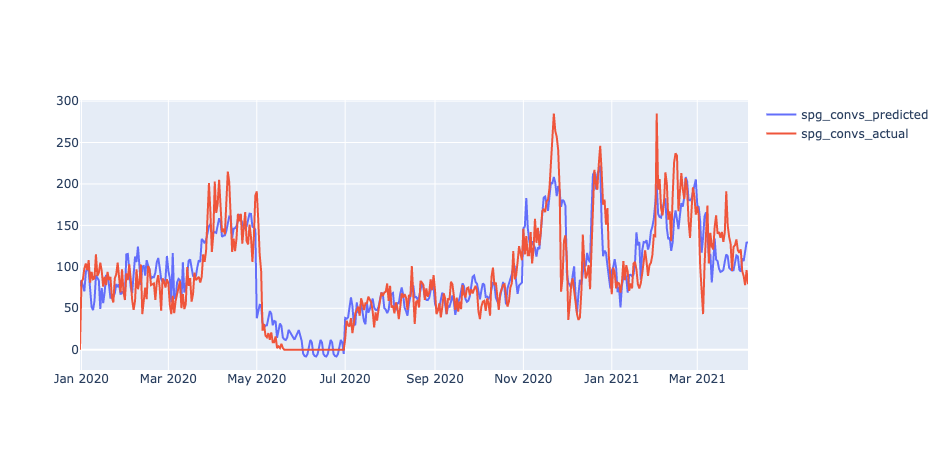

In [902]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_convs_actual'))

fig.show()

__Try holding out the last few months__

In [903]:
is_s = '2020-01-01'
is_e = '2020-12-31'

oos_s = '2021-01-01'
oos_e = '2021-04-01'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [904]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     spg_conversions_all   R-squared:                       0.864
Model:                             OLS   Adj. R-squared:                  0.847
Method:                  Least Squares   F-statistic:                     50.53
Date:                 Mon, 12 Apr 2021   Prob (F-statistic):          1.07e-114
Time:                         13:57:34   Log-Likelihood:                -1600.3
No. Observations:                  360   AIC:                             3283.
Df Residuals:                      319   BIC:                             3442.
Df Model:                           40                                         
Covariance Type:             nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     30.8704      5.543      5.569      0.000      19.965      41.776
impressions_Display - Business As Usual                  1.26e-07    1.8e-07      0.698      0.485   -2.29e-07    4.81e-07
impressions_Display - Content/Audience Development        -0.3182      0.504     -0.631      0.528      -1.310       0.674
impressions_Display - Engagement                         3.18e-07   1.07e-07      2.968      0.003    1.07e-07    5.29e-07
impressions_Display - Gifting                          -5.833e-05   1.65e-05     -3.532      0.000   -9.08e-05   -2.58e-05
impressions_Display - One Day Sale                     -1.364e-07   6.05e-07     -0.226      0.822   -1.33e-06    1.05e-06
impressions_Display - Sale                              1.353e-07   1.56e-07      0.869      0.385   -1.71e-07    4.41e-07
impressions_Display - Testing                           1.546e-05   7.59e-06      2.036      0.043    5.18e-07    3.04e-05
impressions_Native - Business As Usual                  2.767e-07   3.33e-07      0.832      0.406   -3.78e-07    9.31e-07
impressions_Native - Content/Audience Development       1.467e-07   1.38e-07      1.061      0.289   -1.25e-07    4.19e-07
impressions_Native - One Day Sale                       1.296e-08    1.5e-06      0.009      0.993   -2.94e-06    2.96e-06
impressions_Native - Sale                               2.138e-07   2.09e-07      1.025      0.306   -1.97e-07    6.24e-07
impressions_Paid Search - Business As Usual             7.026e-06   3.13e-06      2.248      0.025    8.76e-07    1.32e-05
impressions_Paid Search - Content/Audience Development  7.316e-08   3.67e-08      1.994      0.047    9.59e-10    1.45e-07
impressions_Paid Search - Engagement                    2.344e-07   1.96e-07      1.198      0.232   -1.51e-07    6.19e-07
impressions_Paid Search - Gifting                          0.0005   6.56e-05      8.294      0.000       0.000       0.001
impressions_Paid Search - One Day Sale                  2.033e-05      0.000      0.181      0.856      -0.000       0.000
impressions_Paid Search - Retention                     1.551e-09   1.75e-09      0.889      0.375   -1.88e-09    4.99e-09
impressions_Paid Search - Sale                          1.973e-05   3.09e-06      6.377      0.000    1.36e-05    2.58e-05
impressions_Social - Audience Content                  -6.068e-06   3.84e-06     -1.581      0.115   -1.36e-05    1.49e-06
impressions_Social - Business As Usual                  9.178e-08    8.2e-08      1.120      0.264   -6.95e-08    2.53e-07
impressions_Social - Content/Audience Development      -4.875e-07   1.95e-07     -2.494      0.013   -8.72e-07   -1.03e-

In [905]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

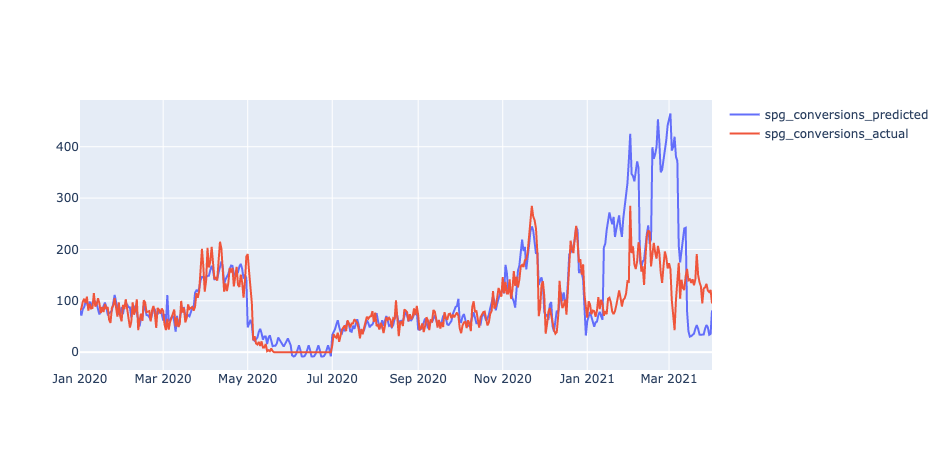

In [906]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_conversions_actual'))

fig.show()

__Try Stepwise__

In [775]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    i = 1
    while remaining and current_score == best_new_score:
        print(f"Iteration: {i}")
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("New best model found")
            print(formula)
        i += 1
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [772]:
stepwise_df = reg_df[is_s:is_e][indep_vars + ['spg_conversions_all']]

In [773]:
stepwise_df.columns = stepwise_df.columns.str.replace(' ', '')
stepwise_df.columns = stepwise_df.columns.str.replace('-','_')
stepwise_df.columns = stepwise_df.columns.str.replace('/','_')

In [907]:
formula = "spg_conversions_all ~ ck_impressions + games_impressions + impressions_Display_Sale + impressions_Social_BusinessAsUsual + impressions_PaidSearch_Sale + month_June + month_April + impressions_PaidSearch_Gifting + impressions_Display_Gifting + month_May + weekday_Sunday + impressions_Native_Content_AudienceDevelopment + weekday_Saturday + weekday_Monday + impressions_Social_Gifting + impressions_Social_Content_AudienceDevelopment + impressions_PaidSearch_BusinessAsUsual + impressions_Display_Testing + month_March + month_July + impressions_Social_X_UNKNOWN_X + weekday_Friday + impressions_Display_BusinessAsUsual + impressions_Display_Content_AudienceDevelopment + 1"
stepwise_model = smf.ols(formula, stepwise_df).fit()

In [908]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     spg_conversions_all   R-squared:                       0.860
Model:                             OLS   Adj. R-squared:                  0.851
Method:                  Least Squares   F-statistic:                     90.06
Date:                 Mon, 12 Apr 2021   Prob (F-statistic):          1.23e-128
Time:                         13:57:42   Log-Likelihood:                -1604.6
No. Observations:                  360   AIC:                             3257.
Df Residuals:                      336   BIC:                             3350.
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          39.0196      4.548      8.580      0.000      30.074      47.965
ck_impressions                                   1.803e-06   9.58e-08     18.825      0.000    1.61e-06    1.99e-06
games_impressions                                 5.53e-07   5.56e-08      9.952      0.000    4.44e-07    6.62e-07
impressions_Display_Sale                          2.36e-07   5.27e-08      4.479      0.000    1.32e-07     3.4e-07
impressions_Social_BusinessAsUsual               5.764e-08   5.28e-08      1.092      0.276   -4.62e-08    1.61e-07
impressions_PaidSearch_Sale                      2.066e-05   2.48e-06      8.345      0.000    1.58e-05    2.55e-05
month_June                                        -46.9267      5.783     -8.114      0.000     -58.303     -35.550
month_April                                        26.4403      7.810      3.385      0.001      11.078      41.803
impressions_PaidSearch_Gifting                      0.0005   6.28e-05      8.267      0.000       0.000       0.001
impressions_Display_Gifting                     -6.445e-05   1.23e-05     -5.221      0.000   -8.87e-05   -4.02e-05
month_May                                         -35.1400      7.067     -4.973      0.000     -49.040     -21.240
weekday_Sunday                                     20.9637      3.576      5.862      0.000      13.929      27.998
impressions_Native_Content_AudienceDevelopment   1.939e-07   1.14e-07      1.697      0.091   -3.09e-08    4.19e-07
weekday_Saturday                                   15.2363      3.563      4.277      0.000       8.228      22.244
weekday_Monday                                     12.4907      3.546      3.522      0.000       5.515      19.467
impressions_Social_Gifting                         -0.0001   2.93e-05     -3.519      0.000      -0.000   -4.56e-05
impressions_Social_Content_AudienceDevelopment  -4.987e-07   1.71e-07     -2.909      0.004   -8.36e-07   -1.62e-07
impressions_PaidSearch_BusinessAsUsual           6.224e-06   1.88e-06      3.316      0.001    2.53e-06    9.92e-06
impressions_Display_Testing                      1.767e-05   7.23e-06      2.443      0.015    3.44e-06    3.19e-05
month_March                                       -17.0655      5.908     -2.889      0.004     -28.686      -5.445
month_July                                         -9.5305      5.403     -1.764      0.079     -20.159       1.098
impressions_Social_X_UNKNOWN_X                   3.043e-06   2.09e-06      1.458      0.146   -1.06e-06    7.15e-06
weekday_Friday                                      4.3360      3.516      1.233      0.218      -2.580      11.252
impressions_Display_BusinessAsUsual              1.661e-

In [910]:
stepwise_df_test = reg_df[oos_s:oos_e][indep_vars]

stepwise_df_test.columns = stepwise_df_test.columns.str.replace(' ', '')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('-','_')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('/','_')

stepwise_df_train = reg_df[is_s:is_e][indep_vars]

stepwise_df_train.columns = stepwise_df_train.columns.str.replace(' ', '')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('-','_')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('/','_')

In [913]:
#####################################
# TRAIN
######################################

stepwise_train_y_pred = stepwise_model.predict(stepwise_df_train)
stepwise_df_train['y_pred'] = stepwise_train_y_pred
stepwise_df_train['y_actual'] = reg_df[is_s:is_e]['spg_conversions_all']

#####################################
# TEST
######################################
stepwise_test_y_pred = stepwise_model.predict(stepwise_df_test)
stepwise_df_test['y_pred'] = stepwise_test_y_pred
stepwise_df_test['y_actual'] = reg_df[oos_s:oos_e]['spg_conversions_all']

######################################
# COMBINE
######################################

stepwise_vis = pd.concat([stepwise_df_train,stepwise_df_test])

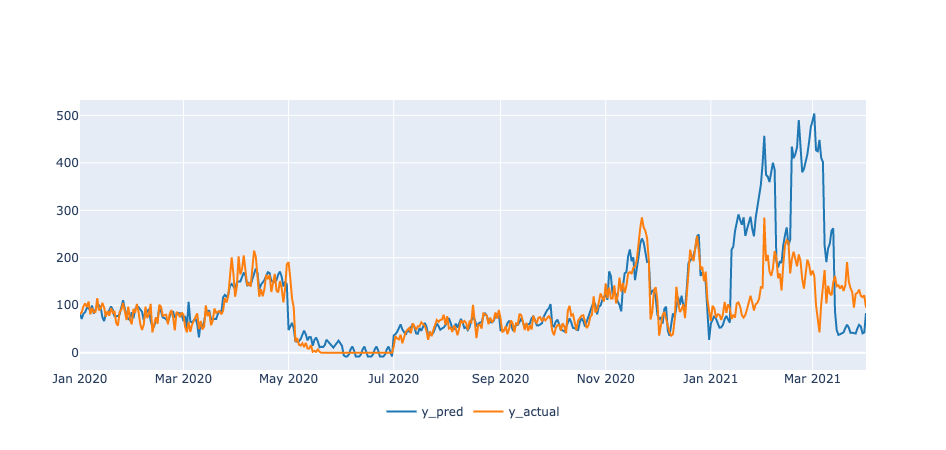

In [914]:
plot_variables(stepwise_vis, ['y_pred','y_actual'], one_plot=True, scaled=False)